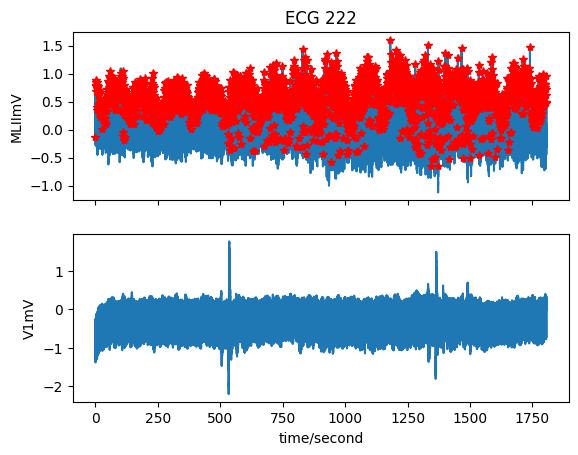

In [19]:
import wfdb
import matplotlib.pyplot as plt

# Chemins complets relatifs
record_path = 'MIT-BIH/records/222'        # sans extension, wfdb cherche .dat et .hea
annotation_path = 'MIT-BIH/annotations/222'  # sans extension, wfdb cherche .atr

# Lire signal et annotation
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(annotation_path, 'atr')

# Visualiser un segment avec annotations
wfdb.plot_wfdb(record=record, annotation=annotation, title='ECG 222')


Informations générales

In [3]:
print("Nombre d'échantillons:", record.p_signal.shape[0])
print("Nombre de canaux:", record.p_signal.shape[1])
print("Fréquence d'échantillonnage:", record.fs)
print("Nombre d'annotations:", len(annotation.sample))
print("Types d'annotations uniques:", set(annotation.symbol))


Nombre d'échantillons: 650000
Nombre de canaux: 2
Fréquence d'échantillonnage: 360
Nombre d'annotations: 2634
Types d'annotations uniques: {'+', 'N', 'A', '~', 'J', 'j'}


Visualisation d’un segment du signal

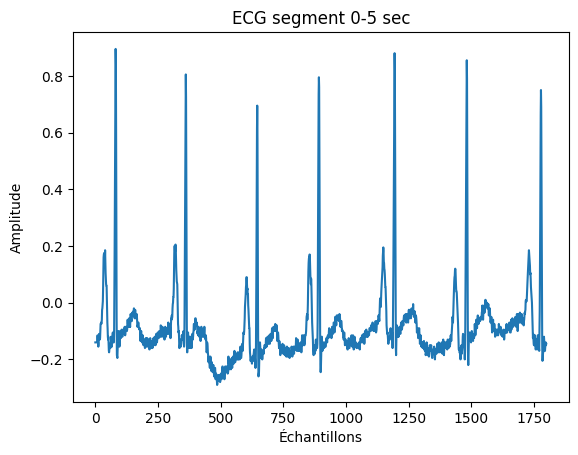

In [4]:
import matplotlib.pyplot as plt

# Visualiser 5 secondes du canal 0
start = 0
end = record.fs * 5  # 5 secondes
plt.plot(record.p_signal[start:end, 0])
plt.title("ECG segment 0-5 sec")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.show()


Visualisation complète avec annotations

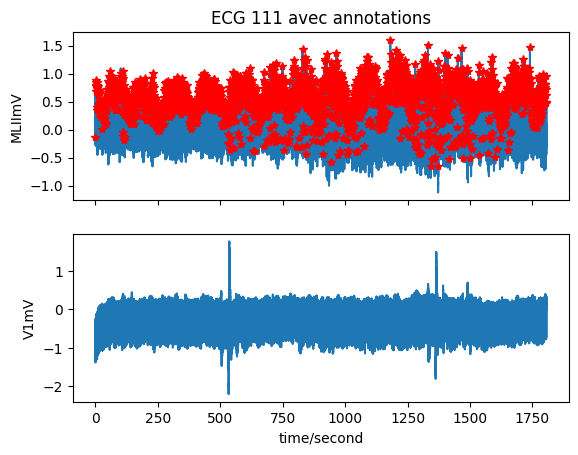

In [5]:
wfdb.plot_wfdb(record=record, annotation=annotation, title="ECG 111 avec annotations")


**Analyse statistique rapide des annotations**

In [6]:
from collections import Counter

annotation_counts = Counter(annotation.symbol)
print("Distribution des types de battements :")
for symbol, count in annotation_counts.items():
    print(f"{symbol}: {count}")


Distribution des types de battements :
+: 136
N: 2062
~: 15
A: 208
j: 212
J: 1


**Préparer les données pour segmentation**

In [7]:
import numpy as np

window_size = record.fs * 2  # 2 secondes
segments = []
labels = []

for idx, sample in enumerate(annotation.sample):
    start = sample - window_size // 2
    end = sample + window_size // 2

    segment = record.p_signal[max(0, start):min(end, len(record.p_signal)), 0]

    # Padding si nécessaire
    if len(segment) < window_size:
        pad_width = window_size - len(segment)
        segment = np.pad(segment, (0, pad_width), 'constant')

    segments.append(segment)
    labels.append(annotation.symbol[idx])

segments = np.array(segments)
labels = np.array(labels)
print("Segments shape:", segments.shape)


Segments shape: (2634, 720)


In [8]:
print("Segments min length:", min(len(s) for s in segments))
print("Segments max length:", max(len(s) for s in segments))


Segments min length: 720
Segments max length: 720


***Filtrage / nettoyage du signal***

In [9]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, low=0.5, high=40, fs=360, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

segments_filtered = np.array([bandpass_filter(seg) for seg in segments])


***Normalisation***

In [10]:
segments_normalized = (segments_filtered - segments_filtered.mean(axis=1, keepdims=True)) / segments_filtered.std(axis=1, keepdims=True)


In [11]:
import numpy as np

# labels = liste originale des labels
# segments = segments correspondants
frequent_classes = ['N', 'A', 'j', '+']

# Créer un masque pour ne garder que les classes fréquentes
mask = np.isin(labels, frequent_classes)

# Appliquer le masque
segments_filtered = segments_normalized[mask]
labels_filtered = np.array(labels)[mask]

print("Nouveau nombre de segments :", len(labels_filtered))
from collections import Counter
print("Distribution après filtrage :", Counter(labels_filtered))

Nouveau nombre de segments : 2618
Distribution après filtrage : Counter({np.str_('N'): 2062, np.str_('j'): 212, np.str_('A'): 208, np.str_('+'): 136})


***Encodage des labels***

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(labels_filtered)  # symbol → entier

# One-hot si Deep Learning
from tensorflow.keras.utils import to_categorical
labels_onehot = to_categorical(labels_encoded)

print("Nombre de classes :", labels_onehot.shape[1])


Nombre de classes : 4


In [13]:
from sklearn.model_selection import train_test_split

# segments_normalized = segments filtrés et normalisés
X_train, X_test, y_train, y_test = train_test_split(
    segments_filtered,   # X
    labels_encoded,        # y en entier
    test_size=0.2,         # 20% test
    random_state=42,
    stratify=labels_encoded  # conserve proportion de chaque classe
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", np.bincount(y_train))  # distribution par classe
print("y_test :", np.bincount(y_test))


X_train: (2094, 720)
X_test : (524, 720)
y_train: [ 109  166 1649  170]
y_test : [ 27  42 413  42]


In [14]:
import pickle

with open('data/ecg_segments_preprocessed.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)


**Class imbalance handling.**
The ECG dataset exhibits a strong class imbalance, with some pathological beat types being underrepresented.
To mitigate model bias toward majority classes, a class-weighted loss is used, assigning higher penalties to errors on minority classes.
This improves sensitivity to rare abnormalities while preserving physiological signal integrity.


In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

#for a clearer print
print("LabelEncoder classes order:", le.classes_)
for idx, w in class_weight_dict.items():
    print(f"Classe {le.classes_[idx]} → weight = {w:.3f}")



{0: np.float64(4.802752293577981), 1: np.float64(3.1536144578313254), 2: np.float64(0.3174651303820497), 3: np.float64(3.0794117647058825)}
LabelEncoder classes order: ['+' 'A' 'N' 'j']
Classe + → weight = 4.803
Classe A → weight = 3.154
Classe N → weight = 0.317
Classe j → weight = 3.079


In [16]:
print(X_train.shape)  # (n_samples, window_size)
print(y_train.shape)  # (n_samples,)


(2094, 720)
(2094,)


In [17]:
from collections import Counter
print("Train distribution:", Counter(y_train))
print("Test distribution :", Counter(y_test))


Train distribution: Counter({np.int64(2): 1649, np.int64(3): 170, np.int64(1): 166, np.int64(0): 109})
Test distribution : Counter({np.int64(2): 413, np.int64(3): 42, np.int64(1): 42, np.int64(0): 27})
